In [1]:
import os
from PIL import Image, ImageDraw
import json
import sys
import csv
import pickle
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['figure.figsize'] = [10, 10]

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Unet architecture

In [2]:
def crop_skip_connection(output, starting_depth, total_depth):
  # starting_depth starts from 1
  original_shape = output.shape[-1]
  final_shape = original_shape
  depth = total_depth - starting_depth
  # encoder pathway
  for i in range(depth):
    final_shape /= 2
    final_shape -= 4
  # decoder pathway
  for i in range(depth):
    final_shape *= 2
    if i != depth-1:
      final_shape -= 4
  margin = (original_shape - final_shape)/2 
  start = int(margin)
  end = int(original_shape - margin)
  output = output[..., start:end, start:end]
  return output

def conv3d(in_channels, out_channels, stride=1, 
            padding=0, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2d(in_channels, out_channels, mode='transpose'):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=2,
        stride=2)


def conv1d(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3d(self.in_channels, self.out_channels)
        ## !TODO: adding batchnorm
        self.conv2 = conv3d(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x  # for skip connection
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2d(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        self.conv1 = conv3d(2*self.out_channels, self.out_channels)

        self.conv2 = conv3d(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up)

        x = torch.cat((from_up, from_down), 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class UNet(nn.Module):

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):

        super(UNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = Encoder(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = Decoder(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1d(outs, self.num_classes)

        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
         
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            cropped = crop_skip_connection(before_pool, i+1, self.depth)
            encoder_outs.append(cropped)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        x = self.conv_final(x)
        return x

# Helper Functions

torch.Size([16, 612, 612])
torch.Size([16, 3, 988, 988])


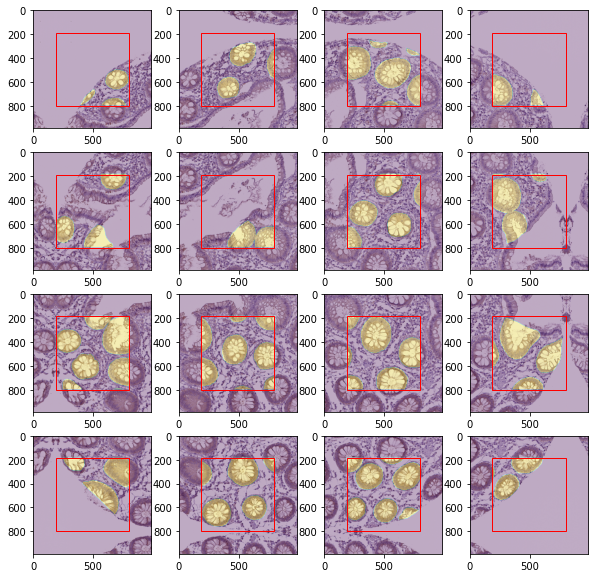

In [18]:
 # Patch function for original Unet

def input_compatible(output_shape, depth):
# Given an output shape of a contracting U-net, calculate the necessary input shape to 
# produce it.
  # Going back through decoder:
  input_shape = float(output_shape)
  for _ in range(depth-1):
    input_shape += 4 # restore borders lost to convolution
    input_shape /= 2 # undo Upampling
    if not input_shape.is_integer():  
      return False 
  # Going back through encoder:
  for i in range(depth):
    input_shape += 4 # restore borders lost to convolution
    if i == depth-1:
      continue
    input_shape *= 2 # undo Downsampling
    if not input_shape.is_integer():  
      return False 
  return input_shape

def Unet_padding(output_shape, depth):
# Returns padding necesary for input on each border for a desired output.
# Output shape should be a scalar (width or height)
  input_shape = input_compatible(output_shape, depth)
  padding =  (input_shape - output_shape) / 2
  return padding

def cut_img(img, label, factor=4, contractingUnet=True, depth=5):
  # Img shape should be (3, height, width), each patch will have heigt = original_height / factor 
  # Label shape should be (height, width)
  # so it produces factor^2 patches
  # If the image height or width is not divisible by the factor, padding with 0 is performed on each side
  # until it is or rows and columns get deleted (preferred).
  assert img.shape[0] == 3, f'img shape must be (3,h,w) but was given {img.shape}'
  assert label.shape[0] == label.shape[1], f'label shape must be (h,w) but was given {label.shape}'

  # Or remove rows and columns from the image
  data = torch.cat([img,label[None, :, :]]) # Should have dim (4, height, width) with 4th channel being the labels
  height = img.shape[1]
  i = 0
  while height % factor != 0:
    data = data[:, :-1, :-1] if i%2==0 else data[:, 1:, 1:] # Remove alternating between top-left and bottom-right
    height = data.shape[1]
    i += 1

  output_shape = height / factor
  img_patches = []
  label_patches = []

  if contractingUnet:
    # Check if tiling is compatible with some Unet input, if not reduce output shape
    while not input_compatible(output_shape, depth):
      output_shape -= 1
    # Reduce image to adapt to new tiling shape
    new_data_shape = output_shape * factor
    i = 0
    while data.shape[-1] != new_data_shape:
      data = data[:, :-1, :-1] if i%2==0 else data[:, 1:, 1:] # Remove alternating between top-left and bottom-right
      i += 1
    # Separate data and labels again, transformation for input_shape is only performed on image data
    labels = data[3]
    img = data[:3]
    # Calculate the padding needed for input to Unet
    padding =  Unet_padding(output_shape, depth) 
    # Cut the image
    for i in range(factor):
      for j in range(factor):
        # Image patch 
        # Location in image:
        h = i * output_shape
        w = j * output_shape
        padding = int(padding)
        # Check if image needs reflection
        top_ref = True if i == 0 else False
        bot_ref = True if i == factor - 1 else False
        left_ref = True if j == 0 else False
        right_ref = True if j == factor - 1 else False
        # Cases
        hl = int(np.maximum(h - padding, 0))
        hr = int(h + padding + output_shape)
        wl = int(np.maximum(w - padding, 0))
        wr = int(w + padding + output_shape)
        patch = img[:, hl:hr, wl:wr]
        if left_ref:
          padder = nn.ReflectionPad2d((padding,0,0,0))
          patch = padder(patch)
        if right_ref:
          padder = nn.ReflectionPad2d((0,padding,0,0))
          patch = padder(patch)
        if top_ref:
          padder = nn.ReflectionPad2d((0,0,padding,0))
          patch = padder(patch)
        if bot_ref:
          padder = nn.ReflectionPad2d((0,0,0,padding))
          patch = padder(patch)
        img_patches.append(patch)
      # Label patch
        hl = int(h)
        hr = int(h + output_shape)
        wl = int(w)
        wr = int(w + output_shape)
        label_patch = labels[hl:hr, wl:wr]
        label_patches.append(label_patch)
  else:
    for i in range(factor):
      for j in range(factor):
        hl = int(i * output_shape)
        wl = int(j * output_shape)
        hr = int(hl + output_shape)
        wr = int(wl + output_shape)
        patch = data[:, hl:hr, wl:wr]
        patches.append(patch)
  img_patches = torch.stack(img_patches)
  label_patches = torch.stack(label_patches)
  # img_patches = patches[:, :3, :, :]
  # label_patches = patches[:, 3, :, :]
  return img_patches, label_patches

im_num = 43 # Cool image, 43, 29
img = dataset[im_num][0]
label = dataset[im_num][1]
impat, labpat = cut_img(img.permute(2,0,1), label, contractingUnet=True, depth=6) 
print(labpat.shape)
print(impat.shape)

# Padding to center the labels and create border to visualize tiling patch
pad = (impat.shape[-1] - labpat.shape[-1])/2
pad = int(pad)
rect_shape = labpat.shape[-1]
padder = nn.ConstantPad2d(pad, 0)
labpat = padder(labpat)

fig, ax = plt.subplots(4,4)
ax = ax.flatten()
for i in range(16):
  ax[i].imshow(unnormalize(impat[i]).permute(1,2,0))
  ax[i].imshow(labpat[i], alpha=0.3)
  rect = patches.Rectangle((pad, pad), rect_shape, rect_shape, linewidth=1, edgecolor='r', facecolor='none')
  ax[i].add_patch(rect)


# Visualize images
# im_num = len(dataset)
# start = 200
# end = 216
# im_num = end - start
# x = math.isqrt(im_num + 1)
# fig, ax = plt.subplots(x,x)
# ax = ax.flatten()
# j = 0
# for i, (img, label) in enumerate(dataset):
#   if i > start:
#     ax[j].imshow(unnormalize(img.permute(2,0,1)).permute(1,2,0))
#     ax[j].imshow(label, alpha=0.1)
#     ax[j].set_title(f"Number {i}")
#     j += 1
#   if i == end-1: break

In [4]:
### ----- Image decoding ----
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

### ----- Cleaning data -------
def remove_white_area(image):
    '''
      output is (2560, 2560, 3) for images and (2560, 2560) for labels
    '''
    size = 2560
    ### images
    if len(image.shape) == 3:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1, :]
        return image[x:y, x:y, :]
      
      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2
      
      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1), (0, 0)), constant_values=(245, 245))
      return np.pad(image, ((x, x), (y, y), (0, 0)), constant_values=(245, 245))
      
    ### labels
    if len(image.shape) == 2:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1]
        return image[x:y, x:y]

      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2

      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1)), constant_values=(0, 0))
      return np.pad(image, ((x, x), (y, y)), constant_values=(0, 0))

### ---- Create and reconstruc patches -------
# Batch patching functions for training
def batch_patches(batch, patch_size, dtype="images", collapse=False):
  # Assuming data in the form (N, 3, height, width) <-images  or (N, height, width) <-labels
  # If collapse is False: Returns tensor (N, img_dim[0] / patch_size, 3, patch_size, patch_size) (image) or same without "3" axis (label)
  # If collapse is True: Returns tensor (N * img_dim[0] / patch_size, 3, patch_size, patch_size) (image) or same without "3" axis (label)
  params = {"images":[2, 3], "labels":[1, 2]}
  params = params[dtype]
  patches = batch.unfold(params[0], patch_size, patch_size).unfold(params[1], patch_size, patch_size)
  if dtype=="images":
    patches = patches.contiguous().view(patches.size(0), patches.size(1), -1, patch_size, patch_size) 
    patches = patches.permute(0,2,1,3,4)
  else:
    patches = patches.contiguous().view(patches.size(0), -1, patch_size, patch_size) 
  if collapse:
    patches = patches.contiguous().view(-1, 3, patch_size, patch_size) if dtype=="images" else \
              patches.contiguous().view(-1, patch_size, patch_size)
  return patches

# Single image patching and reconstruction for prediction
def image_patch(img, patch_size):
  patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
  unfold_shape = patches.shape
  patches = patches.contiguous().view(patches.size(0), -1, patch_size, patch_size) 
  patches = patches.permute(1,0,2,3)
  return patches  

# TODO: finish image_recn function
def image_recon(patches):
  # patches is a tensor of shape (#ofpatches, patch_size, patch_size)
  # Assumes #ofpatches is a perfect square
  shape = patches.shape
  per_row = math.isqrt(shape[0])
  patch_size = shape[1]
  recon = patches.contiguous().view(per_row, per_row, patch_size, patch_size)
  recon = recon.permute(0,2,1,3).reshape(per_row*patch_size, per_row*patch_size)
  return recon


def cuda_mem(x='..'): # Function to check memory in gpu 
  print(f'{torch.cuda.memory_allocated() * 9.3e-10 :.2f} Gb used after: {x}')



######------ Precomputed Parameters-----

# Calculate weights for cross entropy ------- #
# Following this post: https://discuss.pytorch.org/t/choosing-weights-for-weighted-cross-entropy-loss/102240/2
# total = 0
# targets = 0
# for (img, label) in dataset:
#   targets += label.sum()
#   total += label.numel()
# weight_target = total / targets
# weight_bkg = total / (total - targets)
# weight_tensor = torch.tensor([weight_bkg, weight_target]) # I think, since class 0 is background, 1 is target (?)
# weight_tensor = ([1.1527, 7.5491])
weight_tensor = torch.tensor([0.1325, 0.8675])

### ---- Data Normalization ------- #
# This has to be run after changing KaggleDataset to return images transformed by torchvision.transforms.ToTensor
# so the mean and std in the range [0,1] is calculated

# Calculate channel mean across whole dataset
# total_pixels = 0
# total_chan1 = 0
# total_chan2 = 0
# total_chan3 = 0
# for img, label in dataset:
#   img = img.permute(1,2,0)
#   total_pixels += label.shape[0] * label.shape[1]
#   total_chan1 += img[:,:,0].sum()
#   total_chan2 += img[:,:,1].sum()
#   total_chan3 += img[:,:,2].sum()
# mean_chan1 = total_chan1 / total_pixels
# mean_chan2 = total_chan2 / total_pixels
# mean_chan3 = total_chan3 / total_pixels
# mean_tensor = torch.tensor([mean_chan1, mean_chan2, mean_chan3])

# Calculate channel std across whole dataset 
# sqrd_error1 = 0
# sqrd_error2 = 0
# sqrd_error3 = 0
# for img, label in dataset:
#   img = img.permute(1,2,0)
#   sqrd_error1 += (img[:,:,0] - mean_chan1).pow(2).sum()
#   sqrd_error2 += (img[:,:,1] - mean_chan2).pow(2).sum()
#   sqrd_error3 += (img[:,:,2] - mean_chan3).pow(2).sum()
# std1 = torch.sqrt(sqrd_error1 / total_pixels)
# std2 = torch.sqrt(sqrd_error2 / total_pixels)
# std3 = torch.sqrt(sqrd_error3 / total_pixels)
# std_tensor = torch.tensor([std1, std2, std3])

# Mean and Std across whole dataset
mean_tensor = torch.tensor([0.8291, 0.8037, 0.8217])
std_tensor = torch.tensor([0.1692, 0.1958, 0.1842])
# Transformation
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                              mean = mean_tensor,
                                              std = std_tensor)])

def unnormalize(img):
  # expected img dim: (3, height, width)
  # Returns (3, height, width) unnormalized
  mean_tensor = torch.tensor([0.8291, 0.8037, 0.8217])
  std_tensor = torch.tensor([0.1692, 0.1958, 0.1842])
  assert img.shape[0] == 3, f"Img shape should be (3, height, width), got {img.shape}"
  img = img * std_tensor[:, None, None] + mean_tensor[:, None, None]
  return img

## Data set

In [5]:
class KaggleDataset(Dataset):
    #TODO maybe transform as separate function that takes images from KaggleDatabase 
    # and transforms and saves them to the img and label directories
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.labels = pd.read_csv(label_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Labels
        labels = self.labels.iloc[index]
        id = str(labels['id'])
        # Image
        img_path = os.path.join(self.image_dir, id + ".tiff")
        image = np.array(Image.open(img_path).convert("RGB"))
        # rle
        rle = labels['rle']
        decoded_rle = rle_decode(rle, shape = image.shape[:2])

        # Transform
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=annotation)
            image = augmentations["image"]
            annotation = augmentations["annotation"]

        # return torchvision.transforms.ToTensor()(image), decoded_rle
        return transform(remove_white_area(image)).permute(1,2,0), torch.tensor(remove_white_area(decoded_rle))
        # return image, decoded_rle

class PatchDS(Dataset):
    # Class used in training loop to load the patches in a batch 
    def __init__(self, images, labels):
        self.images= images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
      return self.images[index], self.labels[index]


In [6]:
IMAGES_DIRECTORY = "data/train_images/"
ANNOTATION_DIRECTORY = "data/train_annotations/"
TRAIN_LABEL_DIRECTORY = "data/train.csv"

dataset = KaggleDataset(
    image_dir=IMAGES_DIRECTORY,
    label_dir=TRAIN_LABEL_DIRECTORY,
)

# data = dataset[0][0]
# data.shape
# img = unnormalize(data.permute(2,0,1), mean_tensor, std_tensor).permute(1,2,0)
# plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


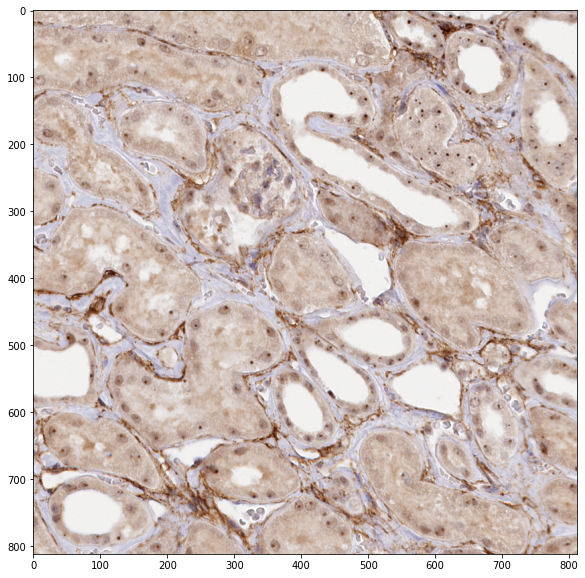

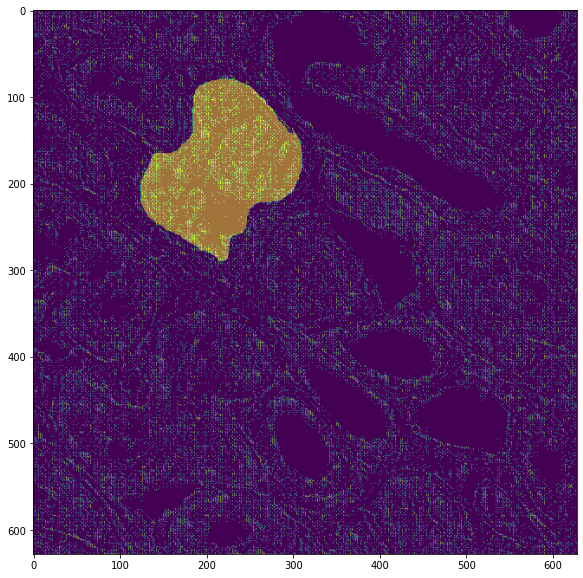

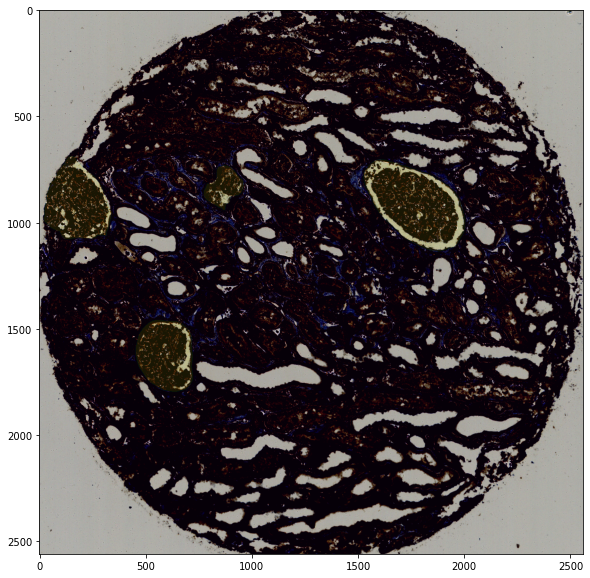

In [36]:
image = 5 
model = UNet(num_classes=2, depth=5, merge_mode='concat')
loader = DataLoader(dataset, batch_size=1, shuffle=False)
for i, (images, labels) in enumerate(loader):
    if i == image:
      images = images.squeeze().permute(2,0,1)
      labels = labels.squeeze()
      image_patches, label_patches = cut_img(images, labels)
      patch_dataset = PatchDS(image_patches, label_patches)
      patch_loader = DataLoader(patch_dataset, batch_size=1, shuffle=False)
      break
for i, (patch, label) in enumerate(patch_loader):
  if i == 5:
    wa = model(patch).squeeze().softmax(0).argmax(0).detach()
    break
# plt.imshow(unnormalize(patch.squeeze()).permute(1,2,0))
# plt.imshow(unnormalize(patch.squeeze()).permute(1,2,0))
fig, ax = plt.subplots(1,1)
ax.imshow(unnormalize(patch.squeeze()).permute(1,2,0))

fig, ax = plt.subplots(1,1)
ax.imshow(label.squeeze())
ax.imshow(wa, alpha=0.5)

fig, ax = plt.subplots(1,1)
data = dataset[image]
img = data[0]
lbl = data[1]
ax.imshow(img)
ax.imshow(lbl, alpha=0.1)

# Training

In [ ]:
# Training the Unet
device = "cuda" if torch.cuda.is_available() else "cpu"

learning_rate = 0.001
nummer_of_epoch = 3

model = UNet(num_classes=2, depth=5, merge_mode='concat').to(device)
#cuda_mem('model')
#criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(device)).to(device) # With weights
criterion = nn.CrossEntropyLoss().to(device) # Without weights
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

number_of_epoch = 3
img_batchsize = 1
patch_batchsize = 2

loss_plot = []
epoch_plot = []

loss_in_epoch = {i:[] for i in range(number_of_epoch)} # To save loss within epoch, every 30 images
for epoch in range(number_of_epoch):
    loss_epoch = []
    loader = DataLoader(dataset, batch_size=img_batchsize, shuffle=True)
    for i, (images, labels) in enumerate(loader):
        images = images.squeeze().permute(2,0,1)
        labels = labels.squeeze()
        image_patches, label_patches = cut_img(images, labels)
        patch_dataset = PatchDS(image_patches, label_patches)
        patch_loader = DataLoader(patch_dataset, batch_size=patch_batchsize, shuffle=True)
        for j, (patches, labels) in enumerate(patch_loader):
            # Forward
            outputs = model(patches.float().to(device))
            labels = labels.long().to(device)
            #cuda_mem('output, labels')
            loss = criterion(outputs, labels)
            #cuda_mem('loss')
            # Backwards
            optimizer.zero_grad()
            loss.backward()
            # gather data
            loss_epoch.append(loss.item())
            break
        if i % 10 == 0:
            if i == 0:
                avg_loss = loss.cpu().detach()            
            else:
                avg_loss = np.array(loss_epoch[-30:]).mean()
            loss_in_epoch[epoch].append(avg_loss)
            print(f'Epoch {epoch}: image: {(i+1) * 3} / {len(dataset)}, loss (last 30) = {avg_loss :.2f}')
    break
    loss_epoch = np.array(loss_epoch)
    loss_plot.append(sum(loss_epoch) / len(loss_epoch))
    epoch_plot.append(epoch)

# Testing and new functions

In [13]:
# Save trained model
torch.save(model, 'model.pth')

# Code for kaggle, saves to /kaggle/working/ 
# torch.save(model, './model.pth')
# np.savetxt("./loss_plot.csv", loss_plot, delimiter=",")
# epoch_plot = np.array(epoch_plot)
# np.savetxt("./epoch_plot.csv", epoch_plot, delimiter=",")
# with open('./in_epoch_loss_dic.pkl', 'wb') as f:
#     pickle.dump(loss_in_epoch, f)

In [22]:
# Load trained model downloaded from kaggle and stored in results
# Notation: d=depth, e=epochs, i=images in batch, b=patchsize_#ofpatchesinbatch, w=weights(True of False)
model_path = 'results/d3_e3_i3_b640_7_wT_Normalized/'
dic_path = model_path + 'in_epoch_loss_dic.pkl'

model = torch.load(model_path + 'model.pth', map_location=torch.device('cpu'))
# with open(dic_path, 'rb') as f:
#     loss_dic = pickle.load(f)
# print(loss_dic)


NameError: name 'loss_dic' is not defined

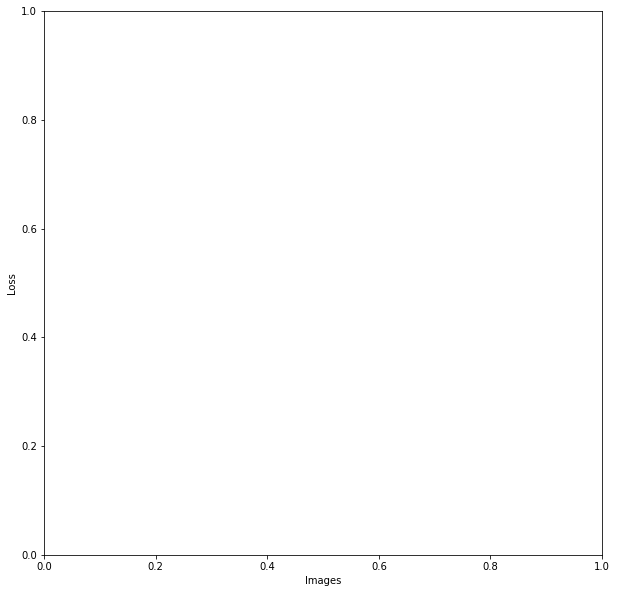

In [15]:
fig, ax = plt.subplots(1)
ax.set_ylabel('Loss')
ax.set_xlabel("Images")
for epoch, losses in loss_dic.items(): 
  x = [i * 30 for i in range(len(losses))]
  ax.plot(x, losses, label=f'Epoch: {epoch}')
ax.legend()
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


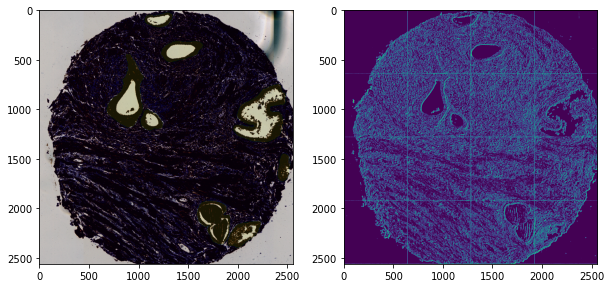

In [24]:
class metamodel():
  def __init__(self, model):
    self.model = model

  def predict(self, image, label):
    # label for plot of target
    # Plot objects
    fig, ax = plt.subplots(1,2)
    ax = ax.flatten()
    ax[0].imshow(img.permute(1,2,0))
    ax[0].imshow(label, alpha=0.1)

    patches = image_patch(image, 320*2)
    prediction = []
    for i, patch in enumerate(DataLoader(patches)):
      patch = patch.float()
      # pred = pred.type(torch.uint8)
      pred = model(patch).squeeze().softmax(0).argmax(0)
      pred = pred.detach()
      prediction.append(pred)
    prediction = torch.stack(prediction)
    prediction = image_recon(prediction)
    # ax[1].imshow(img.permute(1,2,0))
    ax[1].imshow(prediction) #, alpha=0.1)
    return prediction

meta = metamodel(model)
img, label = dataset[7]
img = img.permute(2, 0, 1)
pred = meta.predict(img, label)

In [ ]:
a = (pred==0).count_nonzero()
b = (pred==1).count_nonzero()
c = ( a /(a+b)) * 100
d = (b/(a+b)) * 100
print(c, d)

tensor(40.2083) tensor(59.7917)


In [12]:
test = torch.where(pred>=0.5, 1, 0)
# # test = pred
fig, ax = plt.subplots(1)
# # ax.imshow(img.permute(1,2,0))
ax.imshow(test, alpha=0.2)

NameError: name 'pred' is not defined

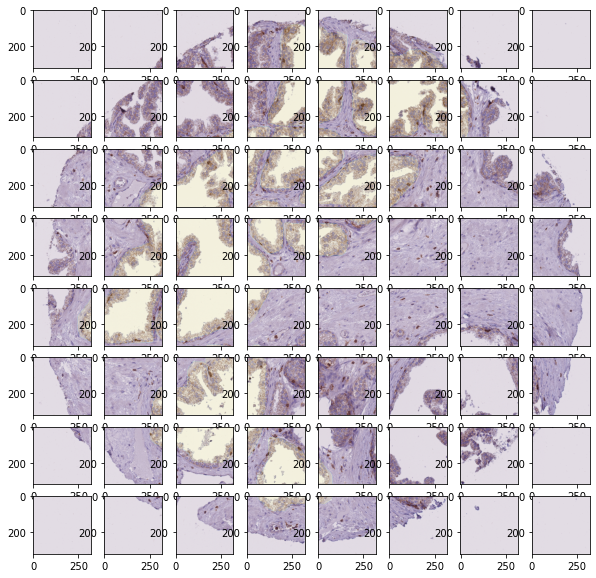

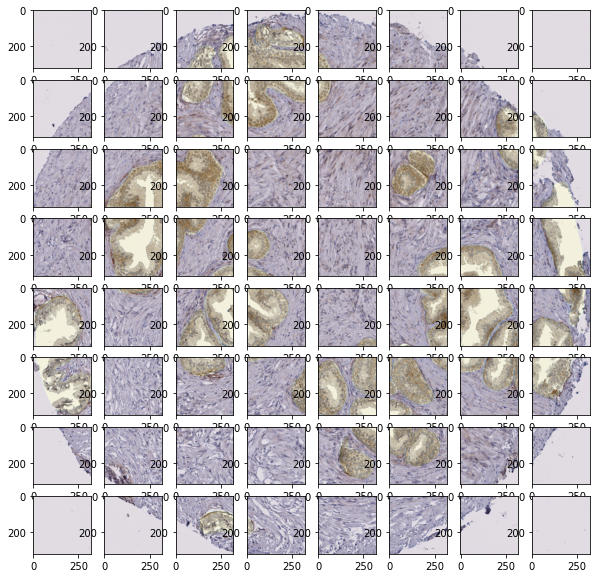

In [146]:
# Testing the PatchDS class
a = img_patches[0]
b = patch_dataset[0]
fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    img, lab = patch_dataset[i]
    img = img.permute(1,2,0)
    ax[i].imshow(img)
    ax[i].imshow(lab, alpha=0.1)

fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    j = 64 + i
    img, lab = patch_dataset[j]
    img = img.permute(1,2,0)
    ax[i].imshow(img)
    ax[i].imshow(lab, alpha=0.1)

In [37]:
# Testing patch function
# Images
image1 = dataset[5][0]
image1 = np.moveaxis(image1, [0, 1, 2], [1, 2, 0])
image1 = torch.from_numpy(image1)
image2 = dataset[6][0]
image2 = np.moveaxis(image2, [0, 1, 2], [1, 2, 0])
image2 = torch.from_numpy(image2)
img_batch = torch.stack([image1, image2])
og_imgshape = img_batch.shape
img_patches, img_ushape = batch_patches(img_batch, 320, dtype="images", recon=True)

# Labels
labels1 = dataset[5][1]
labels1 = torch.from_numpy(labels1)
labels2 = dataset[6][1]
labels2 = torch.from_numpy(labels2)
lab_batch = torch.stack([labels1, labels2])
og_labshape = lab_batch.shape
lab_patches, lab_ushape = batch_patches(lab_batch, 320, dtype="labels", recon=True)

# Plotting and reconstructing
# Img
pieces = 64
img_patches = img_patches.permute(0,1,3,4,2)
img_patches1 = img_patches[0]
lab_patches1 = lab_patches[0]
fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    ax[i].imshow(img_patches1[i])
    ax[i].imshow(lab_patches1[i], alpha=0.1)
img_patches2 = img_patches[1]
lab_patches2 = lab_patches[1]
fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    ax[i].imshow(img_patches2[i])
    ax[i].imshow(lab_patches2[i], alpha=0.1)

TypeError: transpose() received an invalid combination of arguments - got (list), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [30]:
# Class weights for cross entropy
total = 0
targets = 0
for (img, label) in dataset:
  targets += label.sum()
  total += label.numel()
weight_target = total / targets
weight_bkg = total / (total - targets)
weight_tensor = torch.tensor([weight_bkg, weight_target]) # I think, since class 0 is background, 1 is target (?)
